In [1]:
import fastf1
import fastf1.plotting
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import plotly.express as px
# The misc_mpl_mods option enables minor grid lines which clutter the plot
#fastf1.plotting.setup_mpl(misc_mpl_mods=True)
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

Load the race session

In [2]:
# sessions: FPX, Q, R
race = fastf1.get_session(2024, "Austria", 'FP1')
race.load();

req         WARNING 	DEFAULT CACHE ENABLED! (24.0 KB) C:\Users\ivano\AppData\Local\Temp\fastf1


core           INFO 	Loading data for Austrian Grand Prix - Practice 1 [v3.3.0]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading dat

Get all the laps for the point finishers only. Filter out slow laps (yellow flag, VSC, pitstops etc.) as they distort the graph axis.

In [3]:
point_finishers = race.drivers
print(point_finishers)
driver_laps = race.laps.pick_drivers(point_finishers).pick_quicklaps()

driver_laps = driver_laps.reset_index()

['1', '2', '3', '4', '10', '11', '14', '16', '18', '20', '22', '23', '24', '27', '31', '44', '55', '63', '77', '81']


To plot the drivers by finishing order, we need to get their three-letter abbreviations in the finishing order.

In [4]:
finishing_order = [race.get_driver(i)["Abbreviation"] for i in point_finishers]
print(finishing_order)

['VER', 'SAR', 'RIC', 'NOR', 'GAS', 'PER', 'ALO', 'LEC', 'STR', 'MAG', 'TSU', 'ALB', 'ZHO', 'HUL', 'OCO', 'HAM', 'SAI', 'RUS', 'BOT', 'PIA']


We need to modify the DRIVER_COLORS palette. Its keys are the driver’s full names but we need the keys to be the drivers’ three-letter abbreviations. We can do this with the DRIVER_TRANSLATE mapping.

In [5]:
driver_colors = {abv: fastf1.plotting.DRIVER_COLORS[driver] for abv, driver in fastf1.plotting.DRIVER_TRANSLATE.items()}
print(driver_colors)

{'LEC': '#dc0000', 'SAI': '#ff8181', 'SHW': '#9c0000', 'VER': '#fcd700', 'PER': '#ffec7b', 'DEN': '#907400', 'PIA': '#ff8700', 'NOR': '#eeb370', 'OWA': '#ee6d3a', 'GAS': '#fe86bc', 'OCO': '#ff117c', 'DOO': '#894667', 'BOT': '#00e701', 'ZHO': '#008d01', 'POU': '#004601', 'DEV': '#1e3d61', 'TSU': '#356cac', 'RIC': '#2b4562', 'LAW': '#2b4562', 'HAD': '#1e6176', 'MAG': '#ffffff', 'HUL': '#cacaca', 'BEA': '#c40000', 'ALO': '#006f62', 'STR': '#00413b', 'DRU': '#2f9b90', 'HAM': '#00d2be', 'RUS': '#24ffff', 'VES': '#00a6ff', 'ALB': '#005aff', 'SAR': '#012564', 'OSU': '#1b3d97'}


First create the violin plots to show the distributions. Then use the swarm plot to show the actual laptimes.

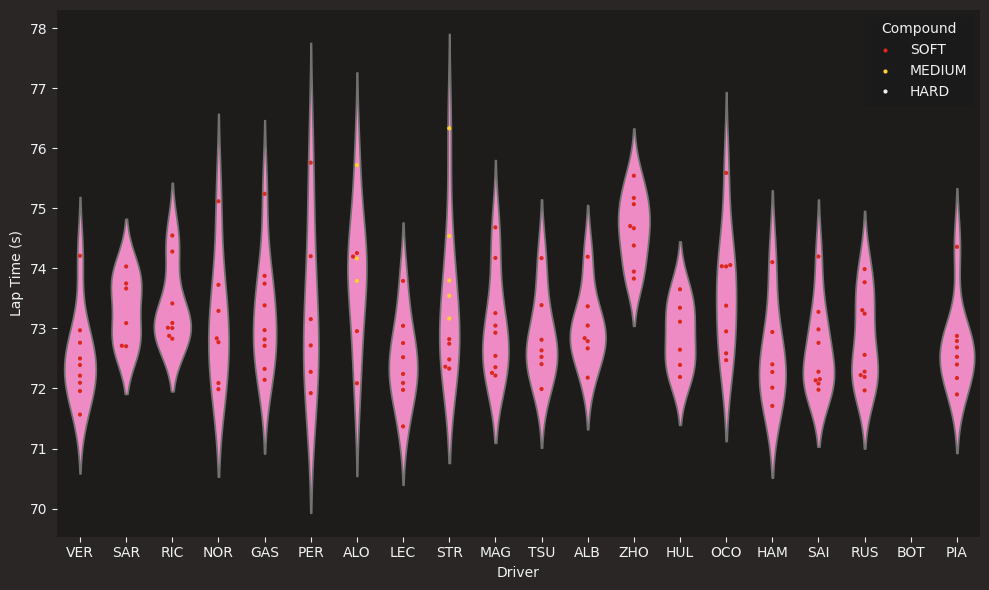

In [6]:
# create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# Seaborn doesn't have proper timedelta support
# so we have to convert timedelta to float (in seconds)
driver_laps["LapTime(s)"] = driver_laps["LapTime"].dt.total_seconds()

sns.violinplot(data=driver_laps,
               x="Driver",
               y="LapTime(s)",
               inner=None,
               density_norm="area",
               order=finishing_order,
               #palette=driver_colors,
               #hue="Driver"
               )

sns.swarmplot(data=driver_laps,
              x="Driver",
              y="LapTime(s)",
              order=finishing_order,
              hue="Compound",
              palette=fastf1.plotting.COMPOUND_COLORS,
              hue_order=["SOFT", "MEDIUM", "HARD"],
              linewidth=0,
              s=3,
              )

ax.set_xlabel("Driver")
ax.set_ylabel("Lap Time (s)")

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show();

In [7]:
loop_drivers = ['VER','PER','SAI','LEC','RUS','HAM','RIC','TSU']
driver_laps_all = pd.DataFrame()
for driver in loop_drivers:
    driver_laps = pd.DataFrame()
    driver_laps = race.laps.pick_accurate().pick_driver(driver ).reset_index()
    driver_laps['LapTimeS'] = driver_laps.LapTime.dt.total_seconds()
    driver_laps['Driver'] = driver
    driver_laps_all = pd.concat([driver_laps_all,driver_laps], ignore_index=True)

driver_laps_all[['Driver','LapNumber','LapTimeS']]

,Driver,LapNumber,LapTimeS
0,VER,2.0,74.209
1,VER,3.0,100.340
2,VER,4.0,84.068
3,VER,5.0,104.477
4,VER,6.0,72.969
...,...,...,...
148,TSU,22.0,112.306
149,TSU,23.0,93.245
150,TSU,24.0,72.635
151,TSU,25.0,90.353


In [8]:
g=px.line(driver_laps_all, x='LapNumber', y='LapTimeS', color='Driver', hover_data=['LapTimeS'])
#formatting options
g.update_layout(title={
        'text': f'Lap times by driver',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        autosize=False,
        width=1200,
        height=400,
        )
g.show()
